# Satellite 🛰️  Data Pre-processing

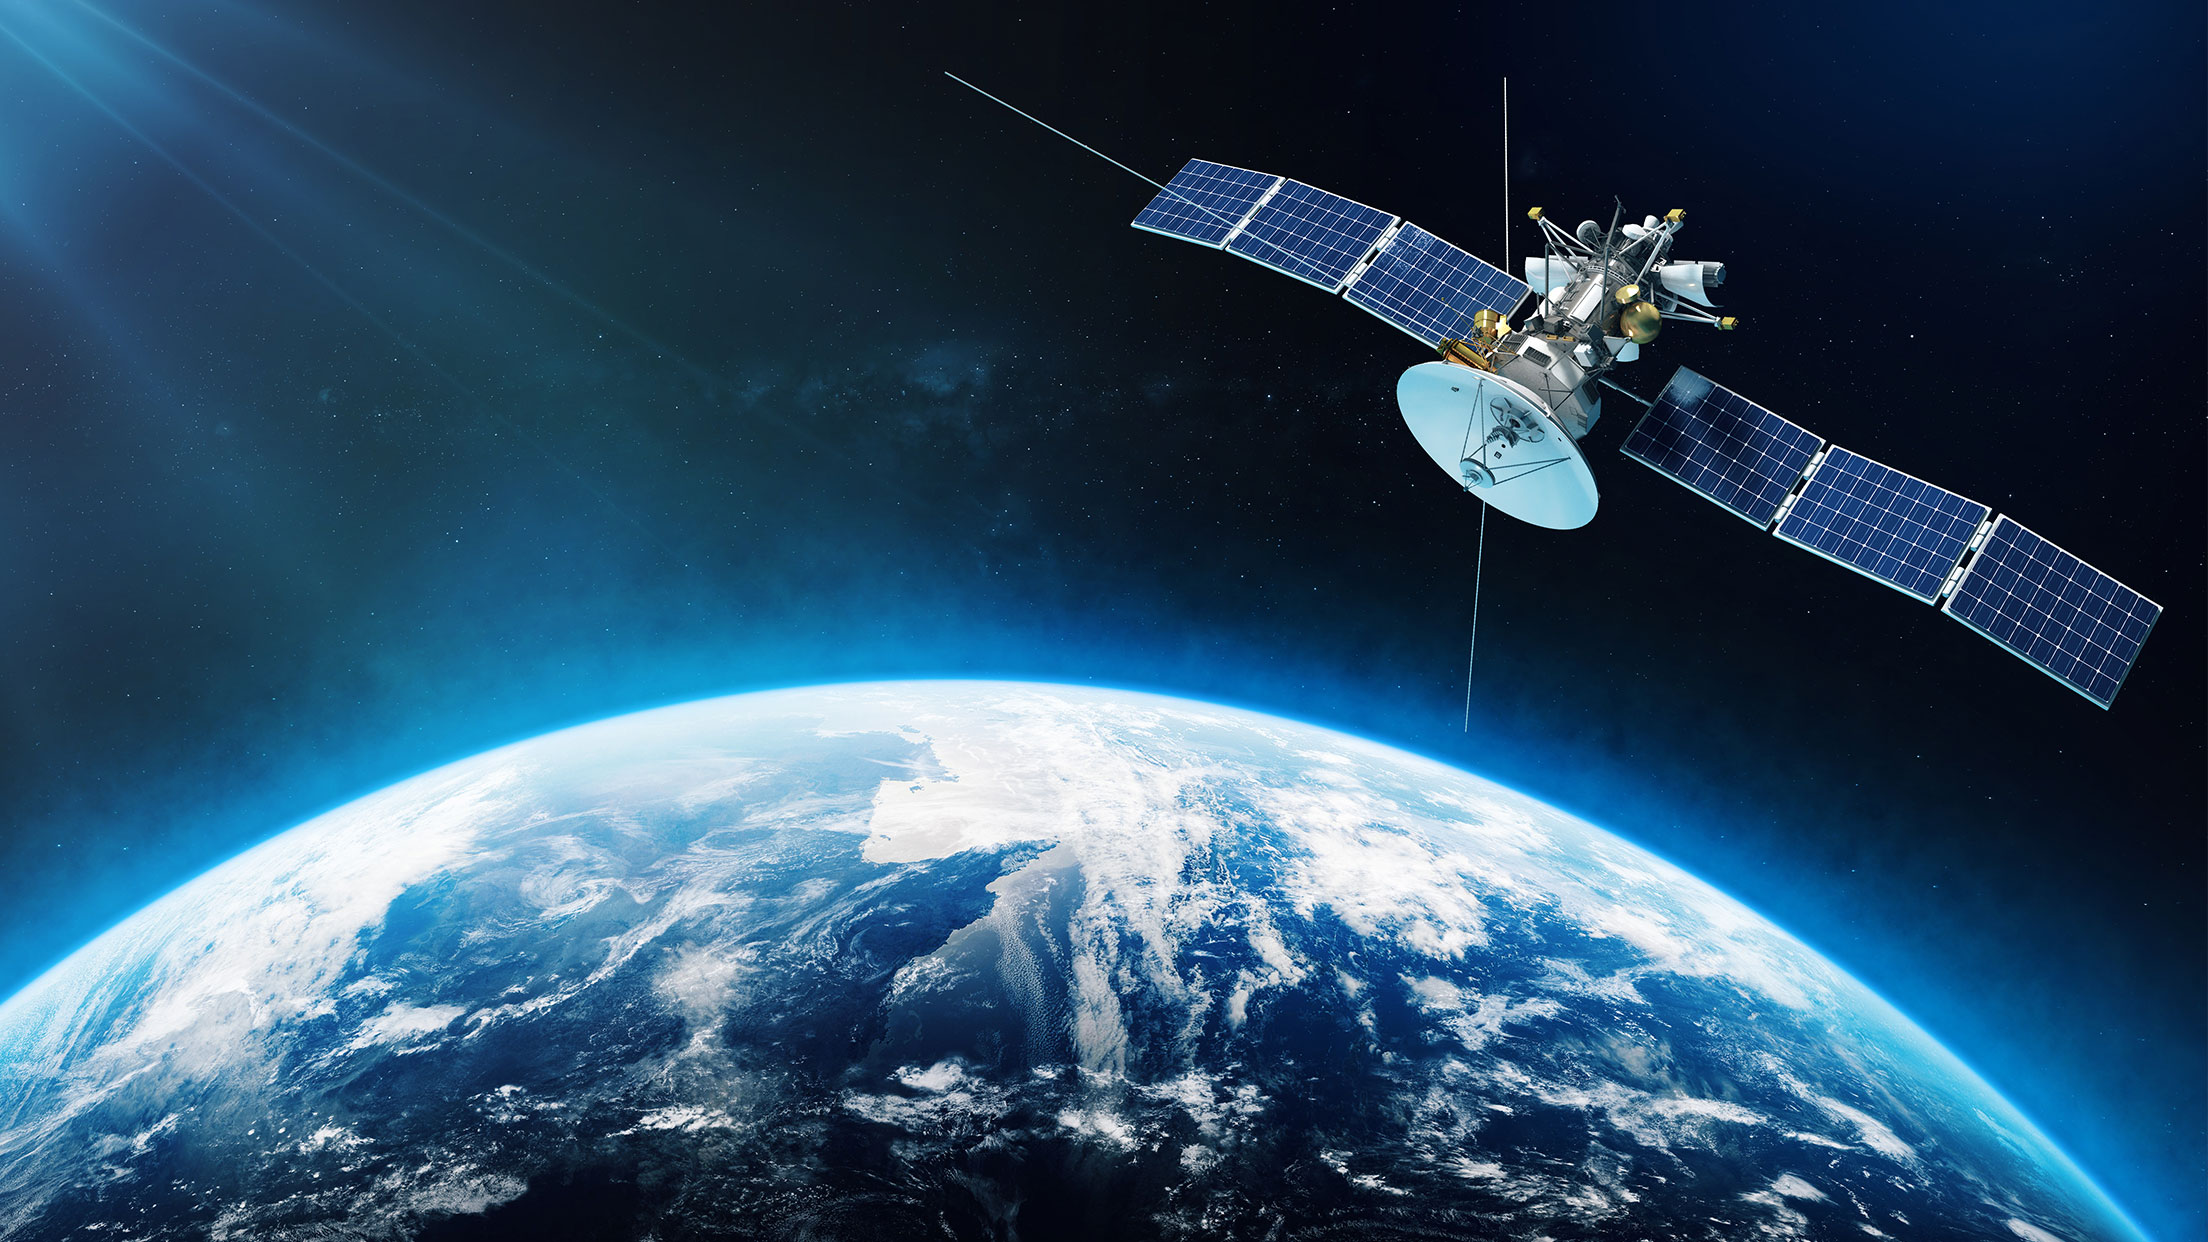

[Image Source](https://www.hytera.com/en/product-new/satellite-communications/satellite-communications-solution.html)



A tutorial delivered at the [Geospatial Machine Learning Workshop](https://dsn.ai/dl-indaba-2023/) at the [2023 Deep Learning Indaba (DLI) Conference](https://deeplearningindaba.com/2023/)

© Deep Learning Indaba 2023. Apache License 2.0.

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/geoai/workshops/GeoAI/Satellite_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** [Ibrahim Salihu Yusuf](https://www.linkedin.com/in/ibrahim-salihu-yusuf-721103100/)

<!-- **Affiliation:** InstaDeep -->

**Introduction:**

Satellites are spaceborne platforms that carry earth observation (EO) sensors and use remote sensing technologies to collect information about the earth. There are numerous satellites orbiting the earth and collecting vast amount of data that can be utilized for:

* Agriculture: crop monitoring
* Forestry: forestry planning and prevention of illegal logging
* Fishing: prevention of illegal fishing
* Energy: pipeline and right-of-way monitoring
* Insurance: infrastructure integrity monitoring
* Land use: infrastructure planning and monitoring of building activity
* Sea traffic: iceberg monitoring, oil spills detection
* Security: coastal traffic monitoring
* Disaster response: fast response to natural catastrophes

Depending on the [type of sensor equipment onboard a satellite](https://www.earthdata.nasa.gov/sensors?page=0), the format of data collected by a satellite can be one of:
* GeoTIFF
* HDF
* NDF
* NITF
* NetCDF
* XML

These variety of data formats have specialized tools used for reading and processing them.

In this tutorial, we will go through how to use a tool called [Xarray](https://docs.xarray.dev/en/stable/) which can be used for reading, processing and writing most of the common satellite data formats including NetCDF, HDF, XML and GeoTIFF.

In [ ]:
# Install required libraries
!pip install -q earthpy rioxarray cftime h5pyd Bottleneck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.0 MB/s eta 0:00:00


In [ ]:
# Import packages

import warnings

import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import random
import numpy as np
import pandas as pd

warnings.simplefilter('ignore')

## Xarray Data Structures & Basic Ops

Before we begin, let's first describe the two main Xarray data structures that we will be using throughout this tutorial.

### DataArray
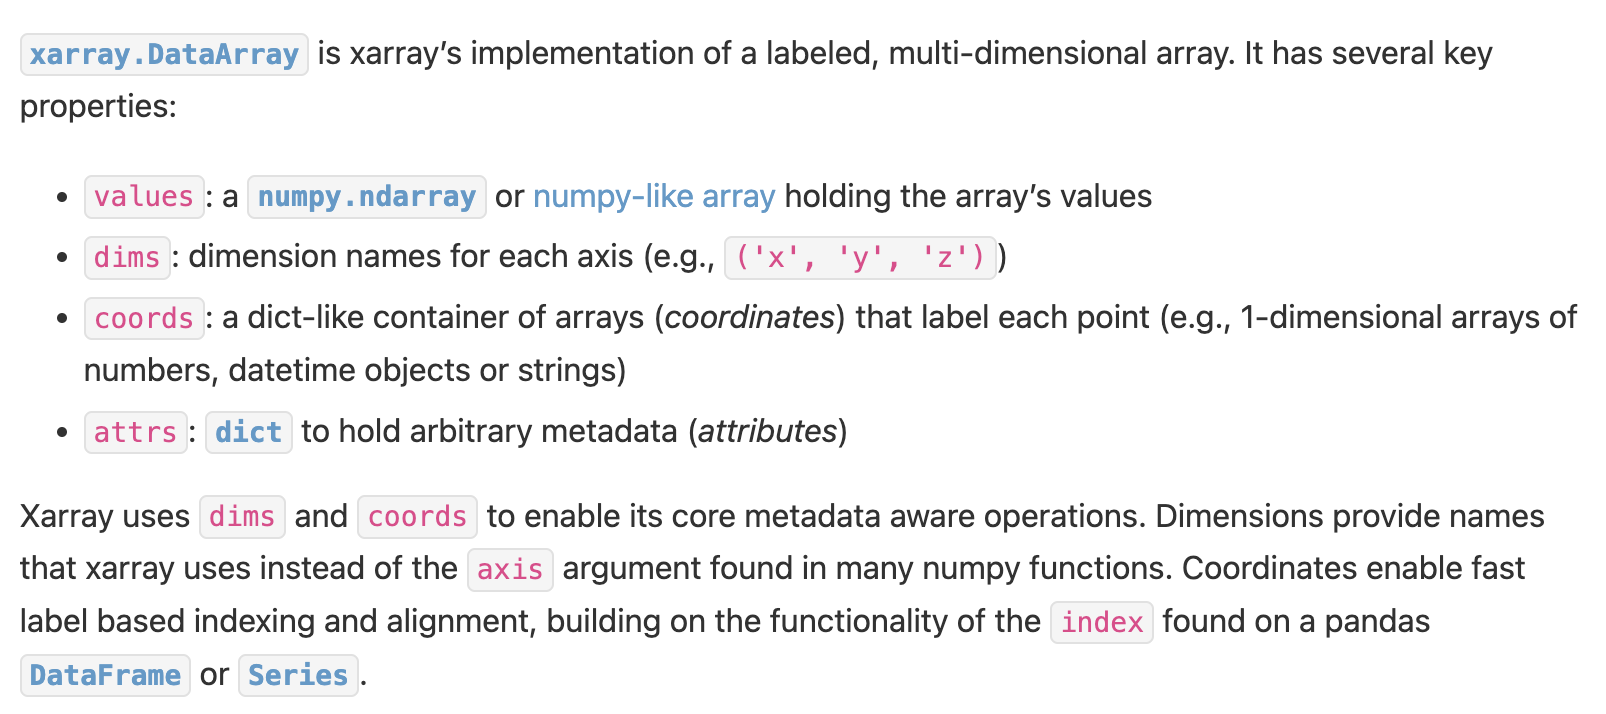

Lets take a look at a simple DataArray

**reference_time** refers to the reference time at which the forecast was made, rather than time which is the valid time for which the forecast applies.

In [ ]:
# Synthetic DataArray

# values
temperature = 15 + 8 * np.random.randn(2, 2, 3)

# coordinates
lon = [[-99.83, -99.32], [-99.79, -99.23]]

lat = [[42.25, 42.21], [42.63, 42.59]]

time = pd.date_range("2014-09-06", periods=3)

reference_time = pd.Timestamp("2014-09-05")

# dataarray
da = xr.DataArray(
    data=temperature,
    dims=["x", "y", "time"],
    coords=dict(
        lon=(["x", "y"], lon),
        lat=(["x", "y"], lat),
        time=time,
        reference_time=reference_time,
    ),
    attrs=dict(
        description="Ambient temperature.",
        units="degC",
    ),
)
da


<xarray.DataArray (x: 2, y: 2, time: 3)>
array([[[20.20025937, 19.00164169, 15.4619437 ],
        [16.38198798, 28.8005458 , 22.82298018]],

       [[16.63620553, 17.65184754, 21.73948302],
        [19.52205243,  7.66599669, 18.6840894 ]]])
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y
Attributes:
    description:  Ambient temperature.
    units:        degC

In [ ]:
print(da)

<xarray.DataArray (x: 2, y: 2, time: 3)>
array([[[20.20025937, 19.00164169, 15.4619437 ],
        [16.38198798, 28.8005458 , 22.82298018]],

       [[16.63620553, 17.65184754, 21.73948302],
        [19.52205243,  7.66599669, 18.6840894 ]]])
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y
Attributes:
    description:  Ambient temperature.
    units:        degC


In [ ]:
da.values

array([[[20.20025937, 19.00164169, 15.4619437 ],
        [16.38198798, 28.8005458 , 22.82298018]],

       [[16.63620553, 17.65184754, 21.73948302],
        [19.52205243,  7.66599669, 18.6840894 ]]])

In [ ]:
da.dims

('x', 'y', 'time')

In [ ]:
da.coords

Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05

In [ ]:
da.attrs

{'description': 'Ambient temperature.', 'units': 'degC'}

### Dataset

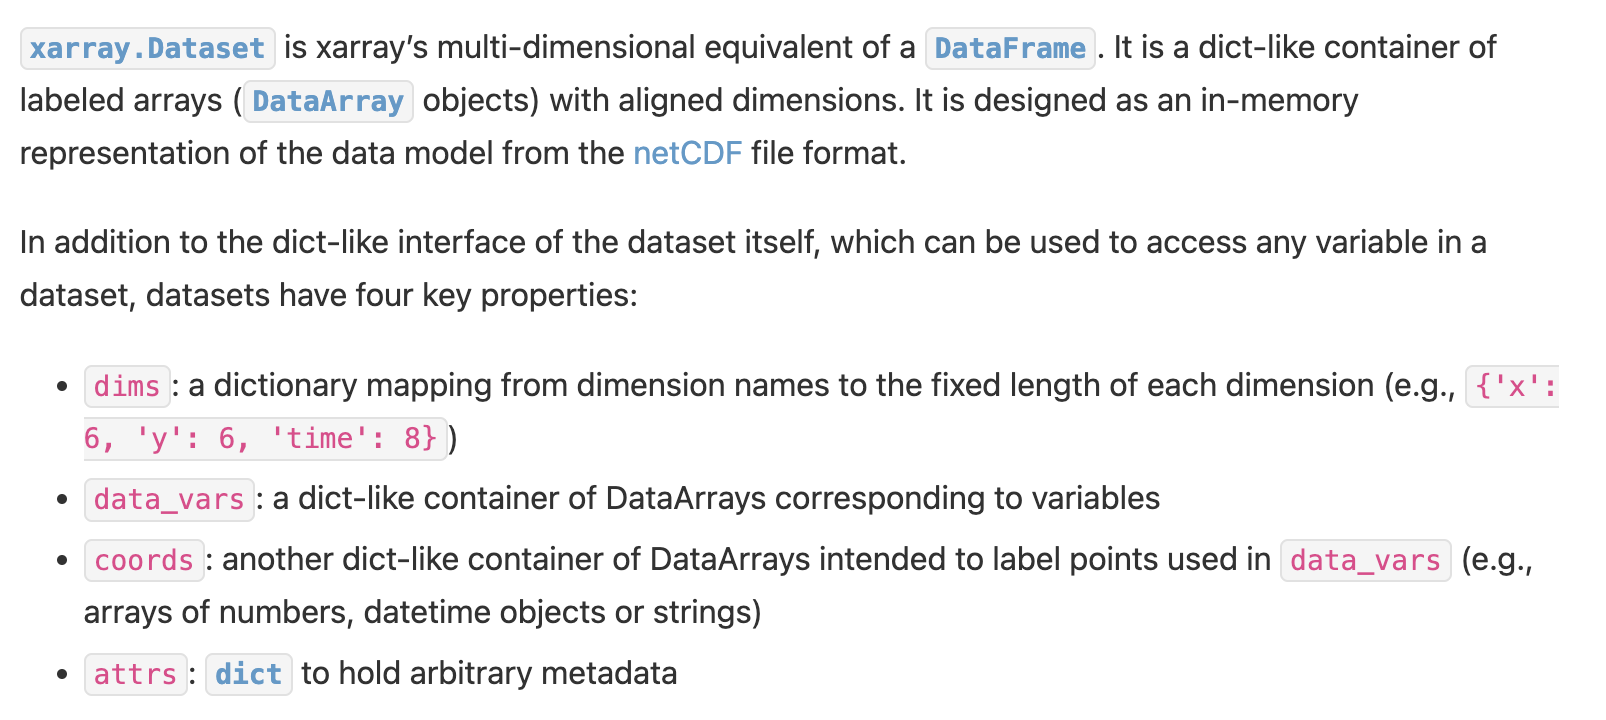

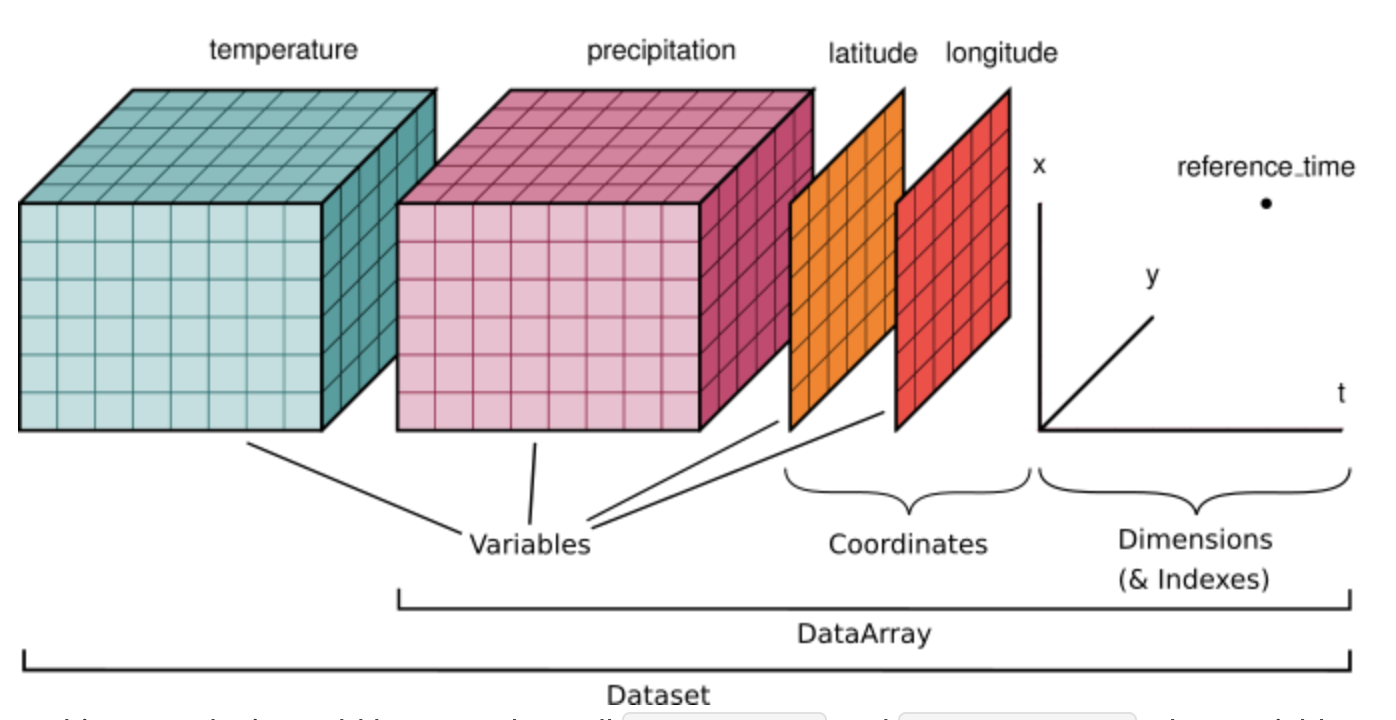

Lets also take a look at a simple Dataset

In [ ]:
# Synthetic Dataset

# variables
temp = 15 + 8 * np.random.randn(2, 2, 3)

precip = 10 * np.random.rand(2, 2, 3)

# coorinates
lon = [[-99.83, -99.32], [-99.79, -99.23]]

lat = [[42.25, 42.21], [42.63, 42.59]]

# dataset
ds = xr.Dataset(
    {
        "temperature": (["x", "y", "time"], temp),
        "precipitation": (["x", "y", "time"], precip),
    },
    coords={
        "lon": (["x", "y"], lon),
        "lat": (["x", "y"], lat),
        "time": pd.date_range("2014-09-06", periods=3),
        "reference_time": pd.Timestamp("2014-09-05"),
    },
)

ds

<xarray.Dataset>
Dimensions:         (x: 2, y: 2, time: 3)
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y
Data variables:
    temperature     (x, y, time) float64 4.27 7.645 18.85 ... 0.6536 1.424 3.844
    precipitation   (x, y, time) float64 9.337 6.617 9.631 ... 3.085 7.229

`Dataset` implements the Python mapping interface, with values given by `xarray.DataArray` objects:

Checking whether the variable 'temperature' is in the dataset


In [ ]:
"temperature" in ds

True

In [ ]:
"humidity" in ds

False

Selecting the variable, which is actually a `DataArray` which forms part of the `Dataset`

In [ ]:
ds["temperature"]

<xarray.DataArray 'temperature' (x: 2, y: 2, time: 3)>
array([[[ 4.2697803 ,  7.64485481, 18.8530452 ],
        [11.73327996,  5.39704642, 18.15353916]],

       [[18.76376511, 19.22123036,  2.44965533],
        [ 0.65358252,  1.42420724,  3.84388906]]])
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y

Data and coordinate variables are also contained separately in the `data_vars` and `coords` dictionary-like attributes

In [ ]:
ds.data_vars

Data variables:
    temperature    (x, y, time) float64 4.27 7.645 18.85 ... 0.6536 1.424 3.844
    precipitation  (x, y, time) float64 9.337 6.617 9.631 ... 0.4262 3.085 7.229

Each of the variables in a `Dataset` is a `DataArray`

In [ ]:
ds['temperature']

<xarray.DataArray 'temperature' (x: 2, y: 2, time: 3)>
array([[[ 4.2697803 ,  7.64485481, 18.8530452 ],
        [11.73327996,  5.39704642, 18.15353916]],

       [[18.76376511, 19.22123036,  2.44965533],
        [ 0.65358252,  1.42420724,  3.84388906]]])
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y

In [ ]:
ds['precipitation']

<xarray.DataArray 'precipitation' (x: 2, y: 2, time: 3)>
array([[[9.33657074, 6.61717642, 9.63101647],
        [6.48752735, 9.93226079, 7.42574206]],

       [[9.23014855, 8.75916866, 8.80141556],
        [0.42622888, 3.08486792, 7.22860251]]])
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y

The coordinates are labels used for indexing each of the dimensions.

In [ ]:
ds.coords

Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05

In [ ]:
ds['lon']

<xarray.DataArray 'lon' (x: 2, y: 2)>
array([[-99.83, -99.32],
       [-99.79, -99.23]])
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y

Like data arrays, datasets also store arbitrary metadata in the form of attributes.

For our synthetic dataset, we did not include any metadata



In [ ]:
ds.attrs

{}

Since the metadata is represented as a mutable `dict` we can update it

In [ ]:
ds.attrs["title"] = "example attribute"
ds.attrs["crs"] = "epsg:4386"

In [ ]:
ds

<xarray.Dataset>
Dimensions:         (x: 2, y: 2, time: 3)
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y
Data variables:
    temperature     (x, y, time) float64 4.27 7.645 18.85 ... 0.6536 1.424 3.844
    precipitation   (x, y, time) float64 9.337 6.617 9.631 ... 3.085 7.229
Attributes:
    title:    example attribute
    crs:      epsg:4386

We can update a dataset in-place using Python's standard dictionary syntax. For example, to create this example dataset from scratch, we could have written:

In [ ]:
ds = xr.Dataset()

ds["temperature"] = (("x", "y", "time"), temp)

ds["temperature_double"] = (("x", "y", "time"), temp * 2)

ds["precipitation"] = (("x", "y", "time"), precip)

ds.coords["lat"] = (("x", "y"), lat)

ds.coords["lon"] = (("x", "y"), lon)

ds.coords["time"] = pd.date_range("2014-09-06", periods=3)

ds.coords["reference_time"] = pd.Timestamp("2014-09-05")

ds

<xarray.Dataset>
Dimensions:             (x: 2, y: 2, time: 3)
Coordinates:
    lat                 (x, y) float64 42.25 42.21 42.63 42.59
    lon                 (x, y) float64 -99.83 -99.32 -99.79 -99.23
  * time                (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time      datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y
Data variables:
    temperature         (x, y, time) float64 4.27 7.645 18.85 ... 1.424 3.844
    temperature_double  (x, y, time) float64 8.54 15.29 37.71 ... 2.848 7.688
    precipitation       (x, y, time) float64 9.337 6.617 9.631 ... 3.085 7.229

### Coordinates

Coordinates are ancillary variables stored for `DataArray` and `Dataset` objects in the coords attribute; it is primary to all operations performed on a `DataArray` or `Dataset`



In [ ]:
ds.coords

Coordinates:
    lat             (x, y) float64 42.25 42.21 42.63 42.59
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05

There are two types of coordinates in xarray:

- dimension coordinates are one dimensional coordinates with a name equal to their sole dimension (marked by * when printing a dataset or data array). They are used for label based indexing and alignment, like the index found on a pandas DataFrame or Series.

- non-dimension coordinates are variables that contain coordinate data, but are not a dimension coordinate. They can be multidimensional, and there is no relationship between the name of a non-dimension coordinate and the name(s) of its dimension(s).

For our synthetic dataset:
- lat: non-dimensional coordinate
- lon: non-dimensional coordinate
- time: dimensional coordinate
- reference_time: non-dimensional coordinate

### Indexing

The most basic way to access elements of a DataArray object is to use Python's [] syntax, such as array[i, j], where i and j are both integers.

As xarray objects can store coordinates corresponding to each dimension of an array, label-based indexing similar to pandas.DataFrame.loc is also possible. In label-based indexing, the element position i is automatically looked-up from the coordinate values.

Read [here](https://docs.xarray.dev/en/stable/user-guide/indexing.html) for more on Indexing

Here is a simple DataArray with two dimensions named `time` and `space`

In [ ]:
da = xr.DataArray(
    np.random.rand(4, 3),
    [
        ("time", pd.date_range("2000-01-01", periods=4)),
        ("space", ["IA", "IL", "IN"]),
    ],
)

Using integer indexing we can select the first two `time` dimenions

In [ ]:
da[:2]

<xarray.DataArray (time: 2, space: 3)>
array([[0.92803269, 0.87945883, 0.53276966],
       [0.52126025, 0.47149754, 0.46263574]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02
  * space    (space) <U2 'IA' 'IL' 'IN'

We can't use integer indexing for dimensions with non-integer coordinates

In [ ]:
da[:, 'IA']

TypeError: ignored

However, we can use the `.loc` label-based indexing similar to pandas.DataFrame.loc

In [ ]:
da.loc[:, 'IA']

In [ ]:
da.loc["2000-01-02", 'IA']

We can specify a slice for non-integer indices

In [ ]:
da.loc["2000-01-01":"2000-01-02", "IA"]

We can also index using dimesion names; by specifying the dimension name and its corresponding value or slice of values

In [ ]:
# Integer selection
da.isel(space=0, time=slice(None, 2))

In [ ]:
# selection using coordinates
da.sel(time=slice("2000-01-01", "2000-01-02"))

#### Nearest-neighbour Lookups

We can query a DataArray at specific coordinates and if it's not available a nearest neighbour lookup can be performed using one of:

- None: only exact matches
- pad / ffill: propagate last valid index value forward
- backfill / bfill: propagate next valid index value backward
- nearest: use nearest valid index value

In [ ]:
da = xr.DataArray([1, 2, 3], [("x", [0, 1, 2])])
da

In [ ]:
# values at indices 1 and 2 are closest to 1.1 and 1.9 respectively

da.sel(x=[1.1, 1.9], method="nearest")

In [ ]:
# remember -> backfill / bfill: propagate next valid index value backward
# value at 1 which is at the 'back' of 0.1 is propagated backward: 0.1 <- 1

da.sel(x=0.1, method="backfill")

In [ ]:
# remember -> pad / ffill: propagate last valid index value forward
# value at 0 -> 0.5, 1 -> 1.5, 2 -> 2.5

da.reindex(x=[0.5, 1, 1.5, 2, 2.5], method="pad")

Instead of relying on one value to fill missing values, we can interpolate. See [interp()](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.interp.html#xarray.Dataset.interp) for more details

Having taken a look at Xarray data structure and basic operations, we can delve into using Xarray to read and process real geospatial data

## Download Data

Having been familiarised with Xarray data structures, we can move to reading some datasets using Xarray.

Let's begin by downloading datasets in different formats from [Earthpy](https://earthpy.readthedocs.io/en/latest/) and [Schubert Research Group](http://schubert.atmos.colostate.edu/)

In [ ]:
et.data.path = "."

et.data.get_data('cs-test-landsat')
et.data.get_data('cold-springs-modis-h4')
et.data.get_data('cold-springs-fire')

Extracted output to ./cs-test-landsat/.
Extracted output to ./cold-springs-modis-h4/.
Extracted output to ./cold-springs-fire/.


'./cold-springs-fire/.'

In [ ]:
!wget 'http://schubert.atmos.colostate.edu/~cslocum/code/air.departure.sig995.2012.nc'

--2023-08-23 06:44:04--  http://schubert.atmos.colostate.edu/~cslocum/code/air.departure.sig995.2012.nc
Resolving schubert.atmos.colostate.edu (schubert.atmos.colostate.edu)... 129.82.48.62
Connecting to schubert.atmos.colostate.edu (schubert.atmos.colostate.edu)|129.82.48.62|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30793837 (29M) [application/x-netcdf]
Saving to: ‘air.departure.sig995.2012.nc’

air.departure.sig99 100%[===================>]  29.37M  29.0MB/s    in 1.0s    

2023-08-23 06:44:06 (29.0 MB/s) - ‘air.departure.sig995.2012.nc’ saved [30793837/30793837]



In [ ]:
hdf_file = "cold-springs-modis-h4/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf"
nc_file = 'air.departure.sig995.2012.nc'
tif_file = 'cs-test-landsat/LC08_L1TP_034032_20160621_20170221_01_T1_sr_band4.tif'

## Reading Data

We will go through how we can use Xarray to read each of these data formats

### NetCDF

In [ ]:
ds = xr.open_dataset(nc_file)

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 366)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
Data variables:
    air_dep  (time, lat, lon) float64 ...
Attributes:
    description:  The departure of the NCEP/NCAR Reanalysis air temperature f...

In some cases where it is desired to read multiple NetCDF files into a single Xarray Dataset, we can specify a glob pattern

In [ ]:
# xr.open_mfdataset('my/files/*.nc', parallel=True)

### HDF
Reading a HDF file using Xarray (Rioxarray) requires a complete installation of GDAL which is not obtainable using `pip install rasterio`.

See [here](https://rasterio.readthedocs.io/en/latest/installation.html#advanced-installation) for a complete installation of GDAL which is required for reading HDF files

In [ ]:
ds = rxr.open_rasterio(hdf_file, engine='h5netcdf')

### GeoTIFF

In [ ]:
ds = xr.open_dataset(tif_file)

In [ ]:
ds

## Coordinate Reference System (CRS)

![picture](https://docs.qgis.org/3.28/en/_images/geographic_crs.png)

A Coordinate reference system (CRS) defines, with the help of coordinates, how the two-dimensional, projected map is related to real locations on the earth.

There are two different types of coordinate reference systems:
* Geographic Coordinate Systems
* Projected Coordinate Systems

The most popular geographic coordinate system is called WGS84 (EPSG:4326). It comprises of lines of latitude that run parallel to the equator and divide the earth into 180 equally spaced sections from North to South (or South to North) and lines of longitude that run perpendicular to the equator and converge at the poles.

Using the geographic coordinate system, we have a grid of lines dividing the earth into squares of 1 degrees (appprox. 111 Km) resolution that cover approximately 12363.365 square kilometres at the equator — a good start, but not very useful for determining the location of anything within that square.

We can divide a map grid into sub-units of degrees such as 0.1 degrees (11.1 km), 0.01 (1.11 km) etc. See [here](https://www.usna.edu/Users/oceano/pguth/md_help/html/approx_equivalents.htm) for approximate metric equivalent of degrees


[Reference](https://docs.qgis.org/3.28/en/docs/gentle_gis_introduction/coordinate_reference_systems.html#overview)

## Shapefile


![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Simple_vector_map.svg/800px-Simple_vector_map.svg.png)


A shapefile is a simple, nontopological format for storing the geometric location and attribute information of geographic features. Geographic features in a shapefile can be represented by points, lines, or polygons (areas).

[Reference](https://desktop.arcgis.com/en/arcmap/latest/manage-data/shapefiles/what-is-a-shapefile.htm)

In [ ]:
%%bash

wget -q -O world_boundaries.zip 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/world-administrative-boundaries/exports/shp'
unzip -q world_boundaries.zip

In [ ]:
shapefile_path = "/content/world-administrative-boundaries.shp"
gdf = gpd.read_file(shapefile_path)

<Axes: >

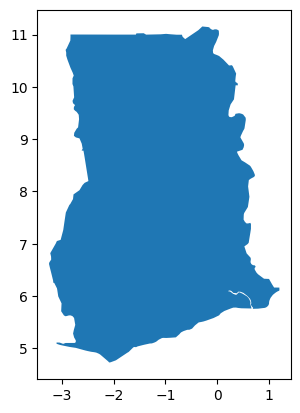

In [ ]:
gdf[gdf['name']=='Ghana'].geometry.plot()

<Axes: >

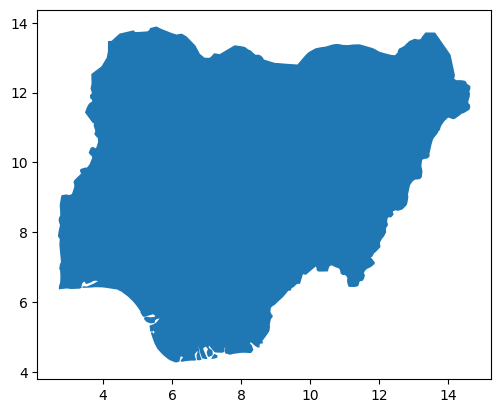

In [ ]:
gdf[gdf['name']=='Nigeria'].geometry.plot()

## Cropping

We can use a shapefile to crop a dataarray. Lets download a global temperature data from [Physical Ssciences Laboratory (PSL)](https://psl.noaa.gov/)

In [ ]:
%%bash

wget -q 'https://downloads.psl.noaa.gov/Datasets/cpc_global_temp/tmin.2013.nc'

In [ ]:
ds = xr.open_dataset('tmin.2013.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 365)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
Data variables:
    tmin     (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/wd52ws/global_temp/
    version:        V1.0
    title:          CPC GLOBAL TEMP V1.0
    dataset_title:  CPC GLOBAL TEMP
    history:        Updated 2019-09-10 20:13:53
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globaltemp...

Here we visualize a map of global minimum temperature for the day 2013-01-01

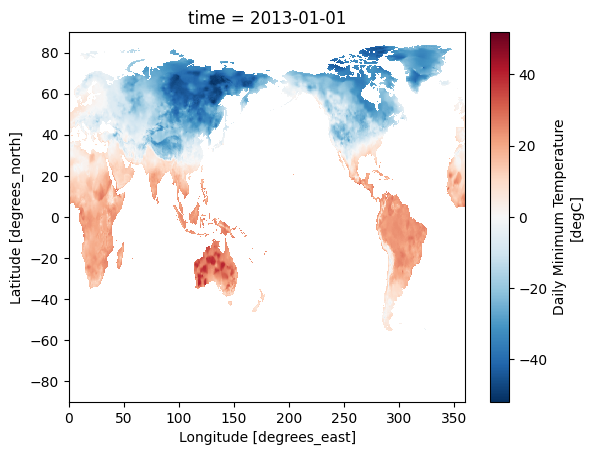

In [ ]:
ds.sel(time='2013-01-01')['tmin'].plot()

To visualize the map for a single country, all we need to do is to use the shapifle for the country to crop the global map

In [ ]:
country = 'Nigeria'

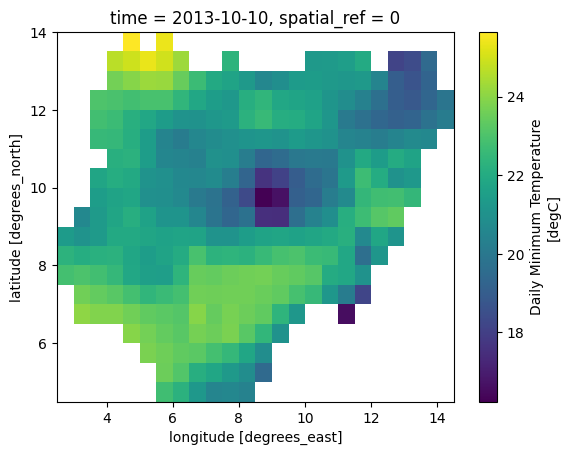

In [ ]:
da  = ds.sel(time='2013-01-01')['tmin']

# we specify the CRS as EPSG:4326
ds.rio.write_crs('epsg:4326', inplace=True)

selected_country_shapefile = gdf[gdf['name']==country].geometry
cropped_ds = ds.rio.clip(selected_country_shapefile)
cropped_ds.sel(time='2013-10-10')['tmin'].plot()

Do you notice that the map is highly pixelated?

This is because the resolution of the data is low

In [ ]:
cropped_ds['lon'][1] - cropped_ds['lon'][0]

<xarray.DataArray 'lon' ()>
array(0.5, dtype=float32)
Coordinates:
    spatial_ref  int64 0

In [ ]:
cropped_ds['lat'][0] - cropped_ds['lat'][1]

<xarray.DataArray 'lat' ()>
array(0.5, dtype=float32)
Coordinates:
    spatial_ref  int64 0

The resolution on both the longitude and latitudes axes is **0.5** degrees which means each pixel covers an approximate area of **3,080** square kilometres.

We can increase/decrease the spatial resolution by resampling

## Resampling (Upsampling/Downsampling)

To upsample an xarray DataArray, you can use the resample() method to change the frequency of the time dimension or the interp() method to increase the resolution of spatial dimensions. Here are examples of both approaches:

Many atimes geospatial datasets would need to be resampled wither by increasing the resolution (upsampling) or decreasing the resolution (downsampling) on either the spatial dimensions (lat/lon) or time dimension.

#### Time Dimension
For example, a dataset may contain weekly records and we desire to resample to daily or monthly. These type of resampling involves the time dimension and we use the `resample()` method of Xarray

In [ ]:
cropped_ds

<xarray.Dataset>
Dimensions:      (lat: 19, lon: 24, time: 365)
Coordinates:
  * lat          (lat) float32 13.75 13.25 12.75 12.25 ... 6.25 5.75 5.25 4.75
  * lon          (lon) float32 2.75 3.25 3.75 4.25 ... 12.75 13.25 13.75 14.25
  * time         (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
    spatial_ref  int64 0
Data variables:
    tmin         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/wd52ws/global_temp/
    version:        V1.0
    title:          CPC GLOBAL TEMP V1.0
    dataset_title:  CPC GLOBAL TEMP
    history:        Updated 2019-09-10 20:13:53
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globaltemp...

Note how the size of the `time` dimension changes from 365 (days) to 53 (weeks)

In [ ]:
weekly_ds = cropped_ds.resample(time='W').interpolate('linear')
weekly_ds

<xarray.Dataset>
Dimensions:      (lat: 19, lon: 24, time: 53)
Coordinates:
  * lat          (lat) float32 13.75 13.25 12.75 12.25 ... 6.25 5.75 5.25 4.75
  * lon          (lon) float32 2.75 3.25 3.75 4.25 ... 12.75 13.25 13.75 14.25
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2013-01-06 2013-01-13 ... 2014-01-05
Data variables:
    tmin         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/wd52ws/global_temp/
    version:        V1.0
    title:          CPC GLOBAL TEMP V1.0
    dataset_title:  CPC GLOBAL TEMP
    history:        Updated 2019-09-10 20:13:53
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globaltemp...

#### Spatial Dimensions
As we saw earlier that our dataset has spatial resolutions of 0.5 degrees (equivalent to 55km) along both latitude and longitude diemensions. This may be too low for some applications.

We can increase/decrease the spatial resolutions of Xarray datarrays by resampling using the `interp()` method

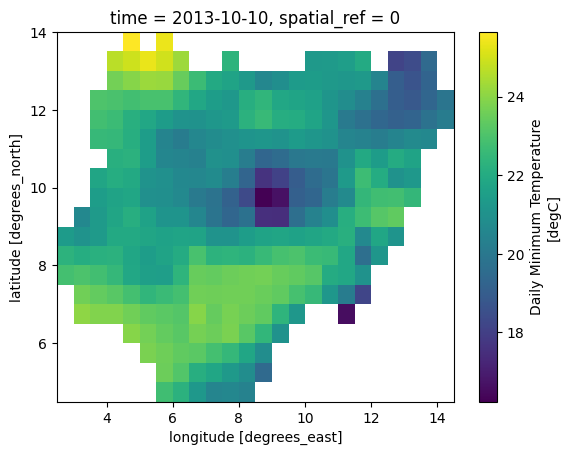

In [ ]:
cropped_ds.sel(time='2013-10-10')['tmin'].plot()

In [ ]:
country_ds = ds.sel(lat=slice(14, 4), lon=slice(3, 14))
country_ds

<xarray.Dataset>
Dimensions:      (lat: 20, lon: 22, time: 365)
Coordinates:
  * lat          (lat) float32 13.75 13.25 12.75 12.25 ... 5.75 5.25 4.75 4.25
  * lon          (lon) float32 3.25 3.75 4.25 4.75 ... 12.25 12.75 13.25 13.75
  * time         (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
    spatial_ref  int64 0
Data variables:
    tmin         (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/wd52ws/global_temp/
    version:        V1.0
    title:          CPC GLOBAL TEMP V1.0
    dataset_title:  CPC GLOBAL TEMP
    history:        Updated 2019-09-10 20:13:53
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globaltemp...

In [ ]:

new_lon = np.linspace(country_ds.lon[0], country_ds.lon[-1], country_ds.dims["lon"] * 4)
new_lat = np.linspace(country_ds.lat[0], country_ds.lat[-1], country_ds.dims["lat"] * 4)

higher_resolution_ds = country_ds.interp(lat=new_lat, lon=new_lon)
higher_resolution_ds

<xarray.Dataset>
Dimensions:      (time: 365, lat: 80, lon: 88)
Coordinates:
  * time         (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
    spatial_ref  int64 0
  * lat          (lat) float64 13.75 13.63 13.51 13.39 ... 4.611 4.491 4.37 4.25
  * lon          (lon) float64 3.25 3.371 3.491 3.612 ... 13.51 13.63 13.75
Data variables:
    tmin         (time, lat, lon) float64 14.41 14.49 14.57 ... 17.94 17.9 17.85
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/wd52ws/global_temp/
    version:        V1.0
    title:          CPC GLOBAL TEMP V1.0
    dataset_title:  CPC GLOBAL TEMP
    history:        Updated 2019-09-10 20:13:53
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globaltemp...

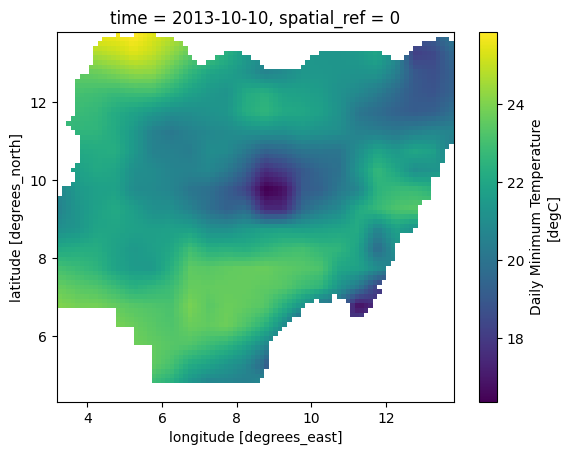

In [ ]:
# we specify the CRS as EPSG:4326
higher_resolution_ds.rio.write_crs('epsg:4326', inplace=True)

selected_country_shapefile = gdf[gdf['name']==country].geometry
higher_resolution_cropped_ds = higher_resolution_ds.rio.clip(selected_country_shapefile)
higher_resolution_cropped_ds.sel(time='2013-10-10')['tmin'].plot()

## Nan-Filling
In many cases geo-spatial datasets have missing values. These missing values can be filled using one of the following methods

* fillna:
* ffill:
* bfill:

### fillna()

When filling missing values using fillna(), we simply place a default value in place of missing values

In [ ]:
temperature = np.array(
    [
        [0, 1, 3],
        [0, np.nan, 5],
        [5, np.nan, np.nan],
        [3, np.nan, np.nan],
        [np.nan, 2, 0],
    ]
)
da = xr.DataArray(
    data=temperature,
    dims=["Y", "X"],
    coords=dict(
        lat=("Y", np.array([-20.0, -20.25, -20.50, -20.75, -21.0])),
        lon=("X", np.array([10.0, 10.25, 10.5])),
    ),
)
da

<xarray.DataArray (Y: 5, X: 3)>
array([[ 0.,  1.,  3.],
       [ 0., nan,  5.],
       [ 5., nan, nan],
       [ 3., nan, nan],
       [nan,  2.,  0.]])
Coordinates:
    lat      (Y) float64 -20.0 -20.25 -20.5 -20.75 -21.0
    lon      (X) float64 10.0 10.25 10.5
Dimensions without coordinates: Y, X

In [ ]:
da.fillna(0)

<xarray.DataArray (Y: 5, X: 3)>
array([[0., 1., 3.],
       [0., 0., 5.],
       [5., 0., 0.],
       [3., 0., 0.],
       [0., 2., 0.]])
Coordinates:
    lat      (Y) float64 -20.0 -20.25 -20.5 -20.75 -21.0
    lon      (X) float64 10.0 10.25 10.5
Dimensions without coordinates: Y, X

We can also fill missing values in a more intutive way by propagating values forward/backward from neighbouring cells

### bfill: Backward Filling



In [ ]:
da.bfill(dim="Y", limit=None)

<xarray.DataArray (Y: 5, X: 3)>
array([[ 0.,  1.,  3.],
       [ 0.,  2.,  5.],
       [ 5.,  2.,  0.],
       [ 3.,  2.,  0.],
       [nan,  2.,  0.]])
Coordinates:
    lat      (Y) float64 -20.0 -20.25 -20.5 -20.75 -21.0
    lon      (X) float64 10.0 10.25 10.5
Dimensions without coordinates: Y, X

Note that the value at index 4 was not filled. This is because there is no value at a higher index that can propagated backward

By specifying `limit=None` it fills all possible missing values. In some cases we may desire to fill only a limited number of missing values. This can be achieved my specifying an integer value to the `limit` argument

In [ ]:
da.bfill(dim="Y", limit=1)

<xarray.DataArray (Y: 5, X: 3)>
array([[ 0.,  1.,  3.],
       [ 0., nan,  5.],
       [ 5., nan, nan],
       [ 3.,  2.,  0.],
       [nan,  2.,  0.]])
Coordinates:
    lat      (Y) float64 -20.0 -20.25 -20.5 -20.75 -21.0
    lon      (X) float64 10.0 10.25 10.5
Dimensions without coordinates: Y, X

### ffill: Forward Filling

In a similar way we can also propagate values at lower indices forward

In [ ]:
da.ffill(dim="Y", limit=None)

<xarray.DataArray (Y: 5, X: 3)>
array([[0., 1., 3.],
       [0., 1., 5.],
       [5., 1., 5.],
       [3., 1., 5.],
       [3., 2., 0.]])
Coordinates:
    lat      (Y) float64 -20.0 -20.25 -20.5 -20.75 -21.0
    lon      (X) float64 10.0 10.25 10.5
Dimensions without coordinates: Y, X

In [ ]:
da.ffill(dim="Y", limit=1)

<xarray.DataArray (Y: 5, X: 3)>
array([[ 0.,  1.,  3.],
       [ 0.,  1.,  5.],
       [ 5., nan,  5.],
       [ 3., nan, nan],
       [ 3.,  2.,  0.]])
Coordinates:
    lat      (Y) float64 -20.0 -20.25 -20.5 -20.75 -21.0
    lon      (X) float64 10.0 10.25 10.5
Dimensions without coordinates: Y, X

## Data Preparation

After reading and cleaning all datasets we can extract values from it using our custom indices for `latitude`, `longitude` and `time`  dimensions.

We first create a synthetic dataset of geolocation (lat and lon) and time.

In [ ]:
lat = np.random.uniform(4, 14, 100).tolist()
lon = np.random.uniform(4, 14, 100).tolist()

dates = pd.date_range(start='2013-01-01', end='2013-12-31', freq='D')
time = random.sample(list(dates), 100)

In [ ]:
data = pd.DataFrame({'lat': lat, 'lon': lon, 'time':time})
data

,lat,lon,time
0,13.180061,8.929334,2013-01-09
1,5.364513,4.920456,2013-08-23
2,13.756448,11.353012,2013-03-09
3,13.499702,5.181799,2013-07-31
4,5.927773,9.751629,2013-06-12
...,...,...,...
95,7.271671,11.647357,2013-03-20
96,12.312628,6.931549,2013-12-13
97,12.379138,8.060788,2013-12-10
98,4.156998,4.373516,2013-02-28


Lets also syntheticaly add more variables to our dataset, so that when we sample we can retrieve four variables including `tmin`, `tmax`, `pressure` and `wind_speed`

In [ ]:
time_dim, lat_dime, lon_dim = higher_resolution_ds['tmin'].shape

higher_resolution_ds['tmax'] = higher_resolution_ds['tmin'] * (1+np.random.rand(time_dim, lat_dime, lon_dim))
higher_resolution_ds['pressure'] = higher_resolution_ds['tmin'] * (np.cos(np.random.rand(time_dim, lat_dime, lon_dim)))
higher_resolution_ds['wind_speed'] = higher_resolution_ds['tmin'] * (np.sin(np.random.rand(time_dim, lat_dime, lon_dim)))

In [ ]:
higher_resolution_ds

<xarray.Dataset>
Dimensions:      (time: 365, lat: 80, lon: 88)
Coordinates:
  * time         (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * lat          (lat) float64 13.75 13.63 13.51 13.39 ... 4.611 4.491 4.37 4.25
  * lon          (lon) float64 3.25 3.371 3.491 3.612 ... 13.51 13.63 13.75
    spatial_ref  int64 0
Data variables:
    tmin         (time, lat, lon) float64 14.41 14.49 14.57 ... 17.94 17.9 17.85
    tmax         (time, lat, lon) float64 16.01 19.66 18.05 ... 34.92 20.09
    pressure     (time, lat, lon) float64 14.41 14.49 10.78 ... 17.9 15.27 17.85
    wind_speed   (time, lat, lon) float64 4.868 10.83 0.7055 ... 11.71 2.472
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/wd52ws/global_temp/
    version:        V1.0
    title:          CPC GLOBAL TEMP V1.0
    dataset_title:  CPC GLOBAL TEMP
    history:        Updated 2019-09-10 20:13:53
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globaltemp...

In [ ]:
dataset = higher_resolution_ds.sel(
    lat=xr.DataArray(data["lat"], dims="z"),
    lon=xr.DataArray(data["lon"], dims="z"),
    time=xr.DataArray(data["time"], dims="z"),
    method='nearest'
)

In [ ]:
dataset

<xarray.Dataset>
Dimensions:      (z: 100)
Coordinates:
    time         (z) datetime64[ns] 2013-01-09 2013-08-23 ... 2013-05-21
    lat          (z) float64 13.15 5.332 13.75 13.51 ... 12.31 12.43 4.25 4.491
    lon          (z) float64 8.922 4.94 11.34 5.181 ... 6.991 8.078 4.336 5.905
    spatial_ref  int64 0
  * z            (z) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    tmin         (z) float64 10.05 nan 21.57 23.45 16.18 ... 22.52 23.09 nan nan
    tmax         (z) float64 14.62 nan 22.63 25.23 27.7 ... 42.07 32.17 nan nan
    pressure     (z) float64 7.831 nan 17.87 23.42 9.304 ... 17.27 16.37 nan nan
    wind_speed   (z) float64 5.594 nan 16.73 4.012 3.067 ... 14.15 13.34 nan nan
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/wd52ws/global_temp/
    version:        V1.0
    title:          CPC GLOBAL TEMP V1.0
    dataset_title:  CPC GLOBAL TEMP
    history:        Updated 2019-09-10 20:13:53
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globaltemp...

In [ ]:
dataset_df = dataset.to_dataframe().reset_index()[['tmin', 'tmax', 'pressure', 'wind_speed']].dropna(how="all")
dataset_df

,tmin,tmax,pressure,wind_speed
0,10.047163,14.615496,7.830581,5.593572
2,21.573554,22.632267,17.866669,16.727485
3,23.449792,25.228247,23.424608,4.012425
4,16.183896,27.702155,9.303994,3.067499
5,20.611146,25.644127,14.401491,6.684064
...,...,...,...,...
93,26.111760,51.096800,17.482019,18.306534
94,22.744631,35.905449,17.050770,18.682711
95,20.790444,27.608959,19.409064,14.896341
96,22.518516,42.067020,17.265358,14.147787


In [ ]:
dataset_df.to_csv('geospatial_dataset.csv')

# Conclusion

We have come to the end of our tutorial on how to read and preprocess satellite data using Xarray and other anciliary libraries.

For more information on how to use Xarray, refer to the [API reference](https://docs.xarray.dev/en/latest/api.html)

Thank you 🙏 all for your time 🕰️